In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from scipy.stats import norm
from scipy.optimize import fsolve
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega

<font size="5">**Question 1**

In [2]:
current_date = date(2022,2,25)
last_date = date(2022,3,18)
T = ((last_date - current_date).days) / 365
S = 165
X = 165
r = 0.0025
dividend_rate = 0.0053
b = r - dividend_rate
sigma = np.linspace(0.1, 0.8, 100)

In [3]:
def BlackScholes (option_type, S, X, T, sigma, r, b):
    d1 = (np.log(S/X) + (b + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S/X) + (b - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    if option_type == "Call" or "call":
        price = S * np.exp((b-r)*T) * norm.cdf(d1,0,1) - X * np.exp(-r*T) * norm.cdf(d2,0,1)
    elif option_type == "Put" or "put":
        price = X * np.exp(-r*T) * norm.cdf(-d2,0,1) - S * np.exp((b-r)*T) * norm.cdf(-d1,0,1)
    else:
        print("Wrong option type")
        return 0
        
    return price

In [4]:
call_value = np.empty(len(sigma))
put_value = np.empty(len(sigma))
for i in range(len(sigma)):
    call_value[i] = BlackScholes("call", S, X, T, sigma[i], r, b)
for i in range(len(sigma)):
    put_value[i] = BlackScholes("put", S, X, T, sigma[i], r, b)

In [5]:
print(call_value)

[ 1.56526555  1.6768696   1.78847274  1.90007481  2.01167571  2.12327533
  2.23487355  2.34647028  2.45806542  2.56965888  2.68125056  2.79284037
  2.90442823  3.01601405  3.12759774  3.23917922  3.3507584   3.4623352
  3.57390953  3.68548132  3.79705047  3.90861691  4.02018056  4.13174132
  4.24329913  4.35485389  4.46640553  4.57795397  4.68949912  4.8010409
  4.91257924  5.02411404  5.13564524  5.24717275  5.35869648  5.47021636
  5.58173232  5.69324425  5.8047521   5.91625577  6.02775518  6.13925027
  6.25074093  6.3622271   6.4737087   6.58518564  6.69665784  6.80812523
  6.91958772  7.03104523  7.14249769  7.25394501  7.36538711  7.47682392
  7.58825535  7.69968132  7.81110175  7.92251657  8.03392569  8.14532904
  8.25672652  8.36811808  8.47950361  8.59088305  8.70225631  8.81362331
  8.92498398  9.03633824  9.147686    9.25902718  9.37036171  9.4816895
  9.59301048  9.70432456  9.81563168  9.92693173 10.03822466 10.14951037
 10.26078879 10.37205984 10.48332343 10.5945795  10.70

In [6]:
print(put_value)

[ 1.56526555  1.6768696   1.78847274  1.90007481  2.01167571  2.12327533
  2.23487355  2.34647028  2.45806542  2.56965888  2.68125056  2.79284037
  2.90442823  3.01601405  3.12759774  3.23917922  3.3507584   3.4623352
  3.57390953  3.68548132  3.79705047  3.90861691  4.02018056  4.13174132
  4.24329913  4.35485389  4.46640553  4.57795397  4.68949912  4.8010409
  4.91257924  5.02411404  5.13564524  5.24717275  5.35869648  5.47021636
  5.58173232  5.69324425  5.8047521   5.91625577  6.02775518  6.13925027
  6.25074093  6.3622271   6.4737087   6.58518564  6.69665784  6.80812523
  6.91958772  7.03104523  7.14249769  7.25394501  7.36538711  7.47682392
  7.58825535  7.69968132  7.81110175  7.92251657  8.03392569  8.14532904
  8.25672652  8.36811808  8.47950361  8.59088305  8.70225631  8.81362331
  8.92498398  9.03633824  9.147686    9.25902718  9.37036171  9.4816895
  9.59301048  9.70432456  9.81563168  9.92693173 10.03822466 10.14951037
 10.26078879 10.37205984 10.48332343 10.5945795  10.70

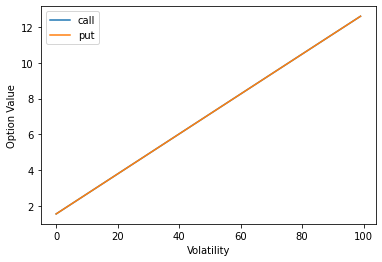

In [7]:
plt.plot(call_value, label='call')
plt.plot(put_value, label = 'put')
plt.ylabel('Option Value')
plt.xlabel('Volatility')
plt.legend()

<font size="5">**Question 2**

In [8]:
aapl = pd.read_csv(r'AAPL_Options.csv')

In [9]:
def impliedVolatility (option_type, S, X, T, r, market_price, tol):
    '''
    S: Underlying Price
    X: Strike Price
    T: Time to Maturity
    r: Risk free rate
    tol: tolerance
    '''
    
    max_iter = 9999
    iv_old = 0.5
    
    for i in range(max_iter):
        bs_price = bs(option_type, S, X, T, r, iv_old)
        vega_price = vega(option_type, S, X, T, r, iv_old) * 100
        gap = bs_price - market_price
        
        iv_new = iv_old - gap/vega_price
        new_bs_price = bs(option_type, S, X, T, r, iv_new)
        
        if (abs(iv_old - iv_new) < tol or abs(new_bs_price - bs_price) < tol):
            break
        
        iv_old = iv_new
        
    impliedVolatility = iv_new
    return impliedVolatility

In [10]:
def getImpVol(option_type, S, X, T, r, market_price):
    
        def vol_helper(sigma):
            result = market_price - BlackScholes(option_type, S, X, T, sigma, r, b) - 0.0001
            return result
   
        impliedVol = fsolve(vol_helper, 0.5)
        return impliedVol

In [11]:
current_date = date(2022,2,25)
last_date = date(2022,3,18)
T = ((last_date - current_date).days) / 365
S = 164.85
r = 0.0025
dividend_rate = 0.0053
b = r - dividend_rate
tol = 1e-9

In [12]:
call_iv = []
put_iv = []
for i in range(len(aapl)):
    X = aapl['Strike'][i]
    market_price = aapl['Last Price'][i]
    option = aapl['Type'][i]
    if option == 'Call':
        call_iv.append(impliedVolatility('c', S, X, T, r, market_price, tol))
    if option == 'Put':
        put_iv.append(impliedVolatility('p', S, X, T, r, market_price, tol))

In [13]:
call_strike = []
put_strike = []
num_call = len(call_iv)
for i in range(num_call):
    call_strike.append(aapl['Strike'][i])
for i in range(num_call, len(aapl)):
    put_strike.append(aapl['Strike'][i])

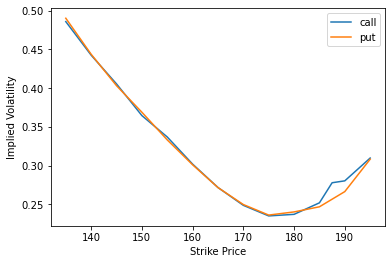

In [14]:
plt.plot(call_strike, call_iv, label = 'call')
plt.plot(put_strike, put_iv, label = 'put')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()

<font size="5">**Question 3**

In [15]:
df = pd.read_csv('problem3.csv')

In [16]:
current_date = date(2022,2,25)
last_date = date(2022,3,18)
T = ((last_date - current_date).days) / 365
current_price = 164.85
r = 0.0025
dividend_rate = 0.0053
b = r - dividend_rate
tol = 1e-5

In [17]:
def port_value(portfolio, underlyingPrice, T, current_price, r, b, tol):
    value = 0
    PnL = 0
    for row in portfolio.itertuples(name = "options"):
        if(getattr(row, 'Type') == 'Stock'):
            value += underlyingPrice * getattr(row, "Holding")
            PnL += (underlyingPrice - current_price) * getattr(row, "Holding")
            
        else:
            X = getattr(row, "Strike")
            market_price = getattr(row, "CurrentPrice")
            if(getattr(row, 'OptionType') == 'Call'):
                iv = getImpVol('Call', underlyingPrice, X, T, r, market_price)
                option_value = BlackScholes('Call', underlyingPrice, X, T, iv[0], r, b)
                value += option_value * getattr(row, "Holding")
                PnL += (option_value - market_price) * getattr(row, "Holding")
                
            else:
                iv = getImpVol('Put', underlyingPrice, X, T, r, market_price)
                option_value = BlackScholes('Put', underlyingPrice, X, T, iv[0], r, b)
                value += option_value * getattr(row, "Holding")
                PnL += (option_value - market_price) * getattr(row, "Holding")
    return value, PnL

In [18]:
groups = df.groupby("Portfolio")
names = list(dict.fromkeys(df['Portfolio']))

In [19]:
def getPort(names):
    plt.figure(figsize = (8,8))
    for name in names:
        value = []
        PnL = []
        port = groups.get_group(name)
        for underlyingPrice in range(150,170):
            value.append(port_value(port, underlyingPrice, T, current_price, r, b, tol)[0])
            PnL.append(port_value(port, underlyingPrice, T, current_price, r, b, tol)[1])
        plt.plot(range(150,170), value, label = name)
        plt.xlabel('Undelying Price')
        plt.ylabel('Portfolio Value')
        plt.legend()

C:\Users\fgfgf\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


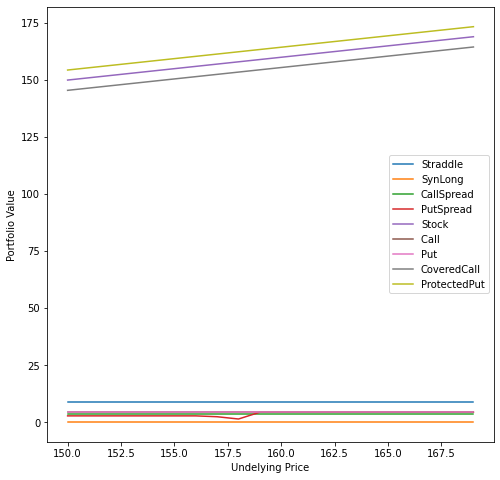

In [20]:
getPort(names)

In [21]:
returns = pd.read_csv("DailyReturn.csv")

In [22]:
r_AAPL = returns["AAPL"] - returns["AAPL"].mean()
std = r_AAPL.std() 

In [23]:
nsim = 10000
T = 10

sim_rets = norm(0, std).rvs((10, nsim))
sim_prices = 164.85 * (1 + sim_rets).prod(axis=0)

In [24]:
def calc_VaR(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

In [25]:
def calc_CVaR(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

In [26]:
VaR = calc_VaR(sim_rets.mean(), std)
CVaR = calc_CVaR(sim_rets.mean(), std)

In [27]:
print(VaR)
print(CVaR)

0.026459130203977405
0.03316386963071315
